In [1]:
import speech_recognition as sr

import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import cess_esp
from nltk.tag.hmm import HiddenMarkovModelTagger

from nltk.chunk.regexp import *

from datetime import datetime
import wikipedia

from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
from lat_lon_parser import parse

import requests, pyttsx3, openai, geopy

from deep_translator import GoogleTranslator

from datetime import timedelta

In [2]:
traductor_es = GoogleTranslator(source='en', target='es')
traductor_en = GoogleTranslator(source='es', target='en')

In [3]:
hmm = HiddenMarkovModelTagger.train(cess_esp.tagged_sents())

In [4]:
def tokenizar(_frase):
    return word_tokenize(_frase)

def taggear(_tokens):
    return hmm.tag(_tokens)

In [5]:
taggear(tokenizar('Alexa dime el tiempo el miercoles en madrid'))

[('Alexa', 'sn.e-SUJ'),
 ('dime', 'vmis3s0'),
 ('el', 'da0ms0'),
 ('tiempo', 'ncms000'),
 ('el', 'da0ms0'),
 ('miercoles', 'ncms000'),
 ('en', 'sps00'),
 ('madrid', 'da0fs0')]

In [6]:
reglas_weather = """
Lugar: {<np.*>}
Lugar: <sps.*> { <da0.* | vmn.*> }
Fecha: { <ncf.*> } <sp.*> <Lugar>
Fecha: <Lugar> { <ncf.*>}
Fecha: { <rg> }
"""
parser_weather = nltk.RegexpParser(reglas_weather)


In [7]:
def extrae_weather(_tree):
    
    result = {}
    
    for nodo in _tree:
        
        if type(nodo) != tuple:
            
            if nodo.label() == 'Lugar':
                lugar = ' '.join([ hoja[0] for hoja in nodo.leaves() ])
                result['lugar'] = lugar
                
                
            if nodo.label() == 'Fecha':
                fecha = ' '.join([ hoja[0] for hoja in nodo.leaves() ])
                result['fecha'] = fecha
                
    if result['fecha'] == 'hoy':
        result['fecha'] = datetime.now().strftime('%Y-%m-%d')
        result['fecha_texto'] = 'mañana'
    elif result['fecha'] == 'mañana':
        result['fecha'] = (datetime.now() + timedelta(days=1)).strftime('%Y-%m-%d')
        result['fecha_texto'] = 'mañana'
        
    latitude, logitude = geopy.geocoders.Nominatim(user_agent="Alexa").geocode(result['lugar'])[1]
    result['latitud'] = latitude
    result['longitud'] = logitude
                
    return result

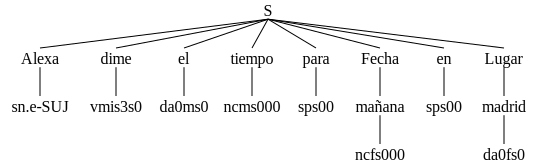

In [8]:
parser_weather.parse(taggear(tokenizar('Alexa dime el tiempo para mañana en madrid')))

In [9]:
weather_extraction = extrae_weather(parser_weather.parse(taggear(tokenizar('Alexa dime el tiempo para mañana en madrid'))))
weather_extraction

{'fecha': '2023-11-29',
 'lugar': 'madrid',
 'fecha_texto': 'mañana',
 'latitud': 40.4167047,
 'longitud': -3.7035825}

In [10]:
def get_openMeteo(_data):
    
    api_url = 'https://api.open-meteo.com/v1/forecast'
    api_params = {
        'latitude': _data['latitud'],
        'longitude': _data['longitud'],
        "daily": ['temperature_2m_max', "temperature_2m_min", "rain_sum", "windspeed_10m_max"],
        "timezone": "Europe/Berlin",
    }
    
    req = requests.get(api_url, params=api_params).json()
    
    pos = 0
    for i in range(len(req['daily'])):
        if req['daily']['time'][i] == _data['fecha']:
            pos = i
    
    result = {"temp_max": req['daily']['temperature_2m_max'][pos], "temp_min": req['daily']['temperature_2m_min'][pos] }
    
    return result

In [11]:
get_openMeteo(weather_extraction)

{'temp_max': 12.6, 'temp_min': 9.7}

In [12]:
def procesa_weather(_frase):
    tokens = tokenizar(_frase)
    tags = taggear(tokens)
    tree = parser_weather.parse(tags)
    tree_info = extrae_weather(tree)
    meteo_info = get_openMeteo(tree_info)
    
    frase = f"""
    El tiempo previso para {tree_info['lugar']} {tree_info['fecha_texto']} es de {meteo_info['temp_max']} grados de máxima y {meteo_info['temp_min']} grados de mínima.
    """
    
    return frase

In [13]:
procesa_weather("Alexa dime el tiempo para mañana en madrid")

'\n    El tiempo previso para madrid mañana es de 12.6 grados de máxima y 9.7 grados de mínima.\n    '